In [13]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score

import os
import sys
import random

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential, load_model

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix

import math
import xgboost as xgb
from xgboost import cv, XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate

ImportError: cannot import name 'builder_impl' from 'tensorflow.python.saved_model' (/Users/michielkoch/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/saved_model/__init__.py)

In [15]:
# hyperparameters

step = 60 
batch_size = 16
#optimizer = optimizers.Adam(lr = 0.001) # learning rate is very low, otherwise the gradients exploded
verbose = 1
data_dir = "C:/Users/086096/thesis_files/"
segment_length = 960
learning_rate = 0.0001

MADRS_LABLES = ['control', 'depression', 'ADHD']
MADRS_VALUES = [0, 7, 20]
classes = len(MADRS_VALUES)

In [25]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [16]:
def create_segments_and_labels_2(dataset_dir, segment_length, step, leave_out_id=None):
    scores = pd.read_csv(os.path.join(dataset_dir, 'scores8.csv'))
    scores['waarde'].fillna(0, inplace=True)
    
    segments = []
    labels = []

    left_out_segments = []
    left_out_correct = None

    if leave_out_id == None:
        leave_out_id = random.randint(0, len(scores['number']))

    for i, person in enumerate(scores['number']):
        p = scores[scores['number'] == person]
        filepath = os.path.join(dataset_dir, person.split('_')[0], f'{person}.csv')
        df_activity = pd.read_csv(filepath)

        p_label = None

        for j in range(classes):
            if p['waarde'].values[0] >= MADRS_VALUES[classes - j - 1]:
                p_label = classes - j - 1
                break

        assert p_label != None, f'Could not get target label: {p}'

        # For the participant that we are leaving out
        if i == leave_out_id:
            left_out_correct = p_label

        for j in range(0, len(df_activity) - segment_length, step):
            segment = df_activity['Magnitude.mean'].values[j : j + segment_length]
            
            #For the participant that we are leaving out
            if i == leave_out_id:
                left_out_segments.append([segment])
            else:
                segments.append([segment])
                labels.append(p_label)

    #assert left_out_correct != None and len(left_out_segments) > 0, f'Did not set data for left out participant {leave_out_id}'
    
    labels = np.asarray(labels).astype('float32')
    labels = to_categorical(labels, 3)
    
    segments = np.asarray(segments).reshape(-1, segment_length, 1)
    #left_out_segments = np.asarray(left_out_segments).reshape(-1, segment_length, 1)

    num_time_periods, num_sensors = segments.shape[1], segments.shape[2]
    input_shape = num_time_periods * num_sensors

    segments = segments.reshape(segments.shape[0], input_shape).astype('float32')
    #left_out_segments = left_out_segments.reshape(left_out_segments.shape[0], input_shape).astype('float32')
    
    return segments, labels, input_shape

In [18]:
print(create_segments_and_labels_2(data_dir,segment_length,step))

(array([[0.043232, 0.08168 , 0.01811 , ..., 0.062163, 0.011337, 0.010288],
       [0.128714, 0.101046, 0.331317, ..., 0.055553, 0.031634, 0.05851 ],
       [0.006379, 0.007886, 0.01208 , ..., 0.016275, 0.085776, 0.035873],
       ...,
       [0.032906, 0.015272, 0.040999, ..., 0.033849, 0.032655, 0.033597],
       [0.152917, 0.136762, 0.040138, ..., 0.032351, 0.032457, 0.035026],
       [0.048456, 0.025114, 0.01568 , ..., 0.033075, 0.032111, 0.032617]],
      dtype=float32), array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32), 960)


In [19]:
segments, labels, input_shape = create_segments_and_labels_2(data_dir, segment_length, step)
print(segments.shape)
print(labels.shape)
print(np.isnan(labels).any())
print(np.isnan(segments).any())

(6216, 960)
(6216, 3)
False
False


In [20]:
labels2 = np.argmax(labels,axis=1)
print(labels2)
print(np.unique(labels2))
print(labels2.shape)

[2 2 2 ... 0 0 0]
[0 1 2]
(6216,)


In [21]:
print(np.count_nonzero(labels2==0))
print(np.count_nonzero(labels2==1))
print(np.count_nonzero(labels2==2))

1981
2056
2179


In [22]:
X_train, X_test, y_train, y_test = train_test_split(segments, labels2, test_size=0.2, random_state=17)

In [23]:
print(X_train)
print(X_train.shape)
print()
print(X_test)
print(X_test.shape)
print()
print(y_train)
print(y_train.shape)
print()
print(y_test)
print(y_test.shape)

[[0.034941 0.076416 0.023302 ... 0.006473 0.009857 0.023   ]
 [0.112649 0.070876 0.075333 ... 0.014467 0.010019 0.019592]
 [0.091136 0.014045 0.028988 ... 0.057241 0.143825 0.04393 ]
 ...
 [0.029489 0.030202 0.107863 ... 0.021551 0.006685 0.008161]
 [0.021478 0.031228 0.030775 ... 0.216109 0.015876 0.067559]
 [0.063361 0.058081 0.02213  ... 0.027908 0.048525 0.024937]]
(4972, 960)

[[0.084742 0.064744 0.09162  ... 0.030405 0.0318   0.036425]
 [0.022447 0.012282 0.044191 ... 0.040516 0.038884 0.019479]
 [0.03455  0.051455 0.039786 ... 0.152746 0.099839 0.131407]
 ...
 [0.019016 0.007512 0.109692 ... 0.034116 0.048256 0.041808]
 [0.012553 0.028148 0.027466 ... 0.012295 0.010849 0.012807]
 [0.133549 0.047302 0.153681 ... 0.011749 0.010347 0.014274]]
(1244, 960)

[0 2 2 ... 0 1 1]
(4972,)

[1 1 2 ... 2 1 2]
(1244,)


16hours - 960timesteps 

In [24]:
XGBClassifier = XGBClassifier()

In [25]:
XGBClassifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [26]:
y_pred = XGBClassifier.predict(X_test)

In [27]:
print(y_pred,y_test)

[0 0 2 ... 2 1 1] [1 1 2 ... 2 1 2]


In [28]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[158 117 111]
 [121 173 128]
 [114  99 223]]
              precision    recall  f1-score   support

           0       0.40      0.41      0.41       386
           1       0.44      0.41      0.43       422
           2       0.48      0.51      0.50       436

    accuracy                           0.45      1244
   macro avg       0.44      0.44      0.44      1244
weighted avg       0.44      0.45      0.44      1244



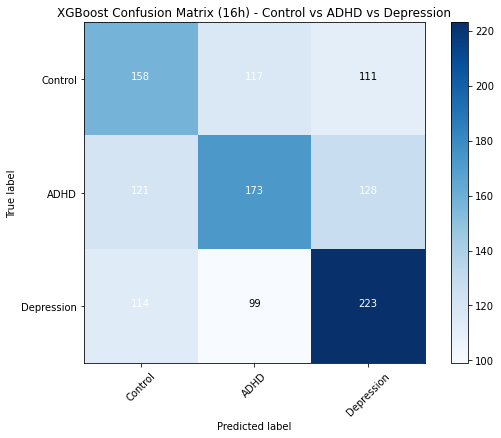

In [26]:
plot_confusion_matrix(cm           = np.array([[ 158,  117,   111],
                                              [  121,  173,  128],
                                              [  114,  99, 223]]), 
                      normalize    = False,
                      target_names = ['Control','ADHD', 'Depression'],
                      title        = "XGBoost Confusion Matrix (16h) - Control vs ADHD vs Depression")

24hours - 1440 timesteps

In [29]:
segment_length = 1440

segments, labels, input_shape = create_segments_and_labels_2(data_dir, segment_length, step)

labels2 = np.argmax(labels,axis=1)

X_train, X_test, y_train, y_test = train_test_split(segments, labels2, test_size=0.2, random_state=17)

print(X_train)
print(X_train.shape)
print()
print(X_test)
print(X_test.shape)
print()
print(y_train)
print(y_train.shape)
print()
print(y_test)
print(y_test.shape)

[[0.173884 0.204942 0.051892 ... 0.013566 0.011535 0.03579 ]
 [0.016478 0.020426 0.035099 ... 0.013003 0.016261 0.01763 ]
 [0.172222 0.120213 0.135648 ... 0.049098 0.068341 0.087943]
 ...
 [0.051    0.018722 0.015858 ... 0.011702 0.008278 0.005995]
 [0.055646 0.01654  0.008941 ... 0.010992 0.018272 0.040151]
 [0.038688 0.045118 0.039088 ... 0.029779 0.007656 0.038697]]
(4602, 1440)

[[0.012648 0.015872 0.013453 ... 0.01267  0.011037 0.049309]
 [0.08697  0.007495 0.038403 ... 0.015863 0.032058 0.0329  ]
 [0.017038 0.014585 0.048723 ... 0.021667 0.179393 0.066999]
 ...
 [0.027326 0.171702 0.020156 ... 0.0903   0.029543 0.052829]
 [0.152652 0.155548 0.033015 ... 0.050656 0.026162 0.031594]
 [0.128399 0.026878 0.02729  ... 0.117164 0.042977 0.172887]]
(1151, 1440)

[1 1 1 ... 0 1 1]
(4602,)

[1 0 2 ... 0 0 2]
(1151,)


In [30]:
XGBClassifier.fit(X_train,y_train)
y_pred = XGBClassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[147  82 123]
 [127 125 121]
 [102  89 235]]
              precision    recall  f1-score   support

           0       0.39      0.42      0.40       352
           1       0.42      0.34      0.37       373
           2       0.49      0.55      0.52       426

    accuracy                           0.44      1151
   macro avg       0.43      0.43      0.43      1151
weighted avg       0.44      0.44      0.44      1151



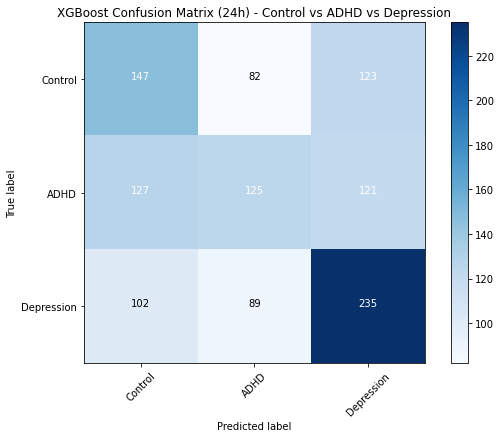

In [27]:
plot_confusion_matrix(cm           = np.array([[ 147,  82,   123],
                                              [  127,  125,  121],
                                              [  102,  89, 235]]), 
                      normalize    = False,
                      target_names = ['Control','ADHD', 'Depression'],
                      title        = "XGBoost Confusion Matrix (24h) - Control vs ADHD vs Depression")

48hours -  2880timesteps

In [31]:
segment_length = 2880

segments, labels, input_shape = create_segments_and_labels_2(data_dir, segment_length, step)

labels2 = np.argmax(labels,axis=1)

X_train, X_test, y_train, y_test = train_test_split(segments, labels2, test_size=0.2, random_state=17)

print(X_train)
print(X_train.shape)
print()
print(X_test)
print(X_test.shape)
print()
print(y_train)
print(y_train.shape)
print()
print(y_test)
print(y_test.shape)

[[0.06143    0.031388   0.014706   ... 0.154954   0.046839   0.030025  ]
 [0.038211   0.029028   0.032203   ... 0.015283   0.042392   0.013764  ]
 [0.17796883 0.09056149 0.06379733 ... 0.03620068 0.01393686 0.03014644]
 ...
 [0.057095   0.038026   0.034732   ... 0.046872   0.076321   0.029698  ]
 [0.060705   0.01765    0.050383   ... 0.00494    0.005689   0.008226  ]
 [0.023784   0.011793   0.026762   ... 0.051317   0.016791   0.067018  ]]
(3520, 2880)

[[0.049624 0.030436 0.044499 ... 0.02599  0.026245 0.026822]
 [0.020455 0.016202 0.017073 ... 0.027419 0.131254 0.082509]
 [0.027378 0.02157  0.021785 ... 0.06897  0.081076 0.039525]
 ...
 [0.048505 0.012797 0.009288 ... 0.053329 0.099509 0.132421]
 [0.023667 0.036584 0.143321 ... 0.00508  0.017142 0.007923]
 [0.028913 0.017869 0.016097 ... 0.013394 0.215686 0.125688]]
(880, 2880)

[1 2 2 ... 2 1 1]
(3520,)

[2 0 1 0 0 2 0 0 1 0 1 2 0 0 0 0 1 0 1 2 1 1 1 1 0 2 0 0 1 1 1 0 2 0 0 1 1
 0 1 1 2 1 0 0 1 1 2 2 2 0 1 2 0 1 0 1 2 2 1 2 0 1 2 2 

In [32]:
XGBClassifier.fit(X_train,y_train)
y_pred = XGBClassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 87  91  90]
 [ 75 128  75]
 [ 52  78 204]]
              precision    recall  f1-score   support

           0       0.41      0.32      0.36       268
           1       0.43      0.46      0.45       278
           2       0.55      0.61      0.58       334

    accuracy                           0.48       880
   macro avg       0.46      0.47      0.46       880
weighted avg       0.47      0.48      0.47       880



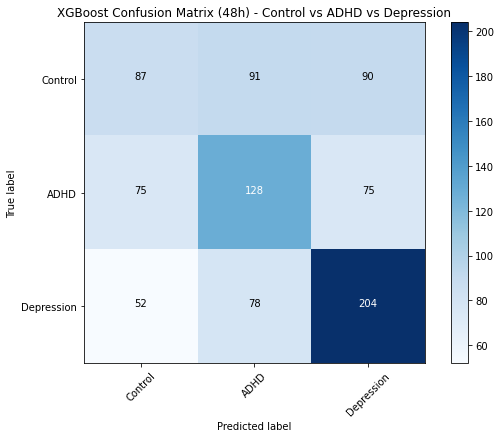

In [28]:
plot_confusion_matrix(cm           = np.array([[ 87,  91,   90],
                                              [  75,  128,  75],
                                              [  52,  78, 204]]), 
                      normalize    = False,
                      target_names = ['Control','ADHD', 'Depression'],
                      title        = "XGBoost Confusion Matrix (48h) - Control vs ADHD vs Depression")

72hours - 4320timesteps

In [33]:
segment_length = 4320

segments, labels, input_shape = create_segments_and_labels_2(data_dir, segment_length, step)

labels2 = np.argmax(labels,axis=1)

X_train, X_test, y_train, y_test = train_test_split(segments, labels2, test_size=0.2, random_state=17)

#print(X_train)
print(X_train.shape)
print()
#print(X_test)
print(X_test.shape)
print()
#print(y_train)
print(y_train.shape)
print()
#print(y_test)
print(y_test.shape)

(2476, 4320)

(620, 4320)

(2476,)

(620,)


In [34]:
XGBClassifier.fit(X_train,y_train)
y_pred = XGBClassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 59  67  57]
 [ 43 101  60]
 [ 36  57 140]]
              precision    recall  f1-score   support

           0       0.43      0.32      0.37       183
           1       0.45      0.50      0.47       204
           2       0.54      0.60      0.57       233

    accuracy                           0.48       620
   macro avg       0.47      0.47      0.47       620
weighted avg       0.48      0.48      0.48       620



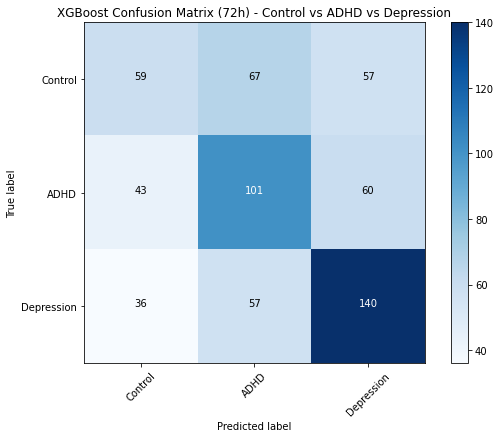

In [29]:
plot_confusion_matrix(cm           = np.array([[ 59,  67,   57],
                                              [  43,  101,  60],
                                              [  36,  57, 140]]), 
                      normalize    = False,
                      target_names = ['Control','ADHD', 'Depression'],
                      title        = "XGBoost Confusion Matrix (72h) - Control vs ADHD vs Depression")

96hours - 5760timesteps

In [35]:
segment_length = 5760

segments, labels, input_shape = create_segments_and_labels_2(data_dir, segment_length, step)

labels2 = np.argmax(labels,axis=1)

X_train, X_test, y_train, y_test = train_test_split(segments, labels2, test_size=0.2, random_state=17)

#print(X_train)
print(X_train.shape)
print()
#print(X_test)
print(X_test.shape)
print()
#print(y_train)
print(y_train.shape)
print()
#print(y_test)
print(y_test.shape)

(1402, 5760)

(351, 5760)

(1402,)

(351,)


In [36]:
XGBClassifier.fit(X_train,y_train)
y_pred = XGBClassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 17  40  40]
 [ 16  60  32]
 [ 13  31 102]]
              precision    recall  f1-score   support

           0       0.37      0.18      0.24        97
           1       0.46      0.56      0.50       108
           2       0.59      0.70      0.64       146

    accuracy                           0.51       351
   macro avg       0.47      0.48      0.46       351
weighted avg       0.49      0.51      0.49       351



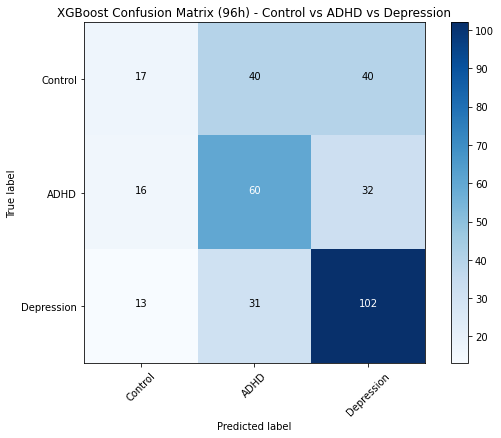

In [30]:
plot_confusion_matrix(cm           = np.array([[ 17,  40,   40],
                                              [  16,  60,  32],
                                              [  13,  31, 102]]), 
                      normalize    = False,
                      target_names = ['Control','ADHD', 'Depression'],
                      title        = "XGBoost Confusion Matrix (96h) - Control vs ADHD vs Depression")

16h

[[158 117 111]
 [121 173 128]
 [114  99 223]]
              precision    recall  f1-score   support

           0       0.40      0.41      0.41       386
           1       0.44      0.41      0.43       422
           2       0.48      0.51      0.50       436

    accuracy                           0.45      1244
   macro avg       0.44      0.44      0.44      1244
weighted avg       0.44      0.45      0.44      1244

24h 

[[147  82 123]
 [127 125 121]
 [102  89 235]]
              precision    recall  f1-score   support

           0       0.39      0.42      0.40       352
           1       0.42      0.34      0.37       373
           2       0.49      0.55      0.52       426

    accuracy                           0.44      1151
   macro avg       0.43      0.43      0.43      1151
weighted avg       0.44      0.44      0.44      1151

48h

[[ 87  91  90]
 [ 75 128  75]
 [ 52  78 204]]
              precision    recall  f1-score   support

           0       0.41      0.32      0.36       268
           1       0.43      0.46      0.45       278
           2       0.55      0.61      0.58       334

    accuracy                           0.48       880
   macro avg       0.46      0.47      0.46       880
weighted avg       0.47      0.48      0.47       880

72h

[[ 59  67  57]
 [ 43 101  60]
 [ 36  57 140]]
              precision    recall  f1-score   support

           0       0.43      0.32      0.37       183
           1       0.45      0.50      0.47       204
           2       0.54      0.60      0.57       233

    accuracy                           0.48       620
   macro avg       0.47      0.47      0.47       620
weighted avg       0.48      0.48      0.48       620

96h

[[ 17  40  40]
 [ 16  60  32]
 [ 13  31 102]]
              precision    recall  f1-score   support

           0       0.37      0.18      0.24        97
           1       0.46      0.56      0.50       108
           2       0.59      0.70      0.64       146

    accuracy                           0.51       351
   macro avg       0.47      0.48      0.46       351
weighted avg       0.49      0.51      0.49       351

In [3]:
import numpy as np

In [22]:
np.mean([24,50,64])

46.0

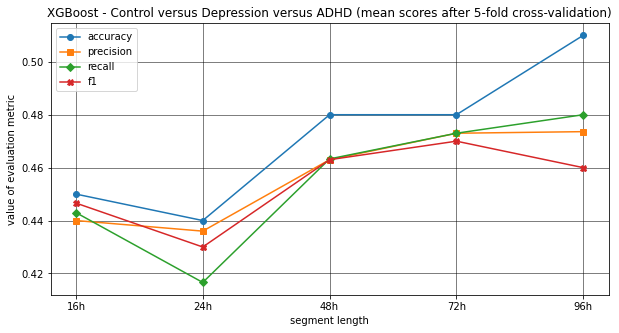

In [24]:
acc = [0.45,0.44,0.48,0.48,0.51]
prec = [0.44,0.436,0.463,0.473,0.4736]
reca = [0.443,0.4166,0.4633,0.473,0.48]
f1 = [0.4466,0.43,0.463,0.47,0.46]
acc_perc = np.multiply(acc, 1)
prec_perc = np.multiply(prec, 1)
reca_perc = np.multiply(reca, 1)
f1_perc = np.multiply(f1, 1)

plt.figure(figsize=(10, 5))
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.plot(acc_perc, marker = 'o')
plt.plot(prec_perc, marker = 's')
plt.plot(reca_perc, marker = 'D')
plt.plot(f1_perc, marker = 'X')
plt.xticks(np.arange(5),['16h','24h','48h','72h','96h'])
plt.legend(['accuracy','precision','recall','f1'])
plt.title("XGBoost - Control versus Depression versus ADHD (mean scores after 5-fold cross-validation)")
plt.xlabel('segment length')
plt.ylabel('value of evaluation metric')
plt.show()

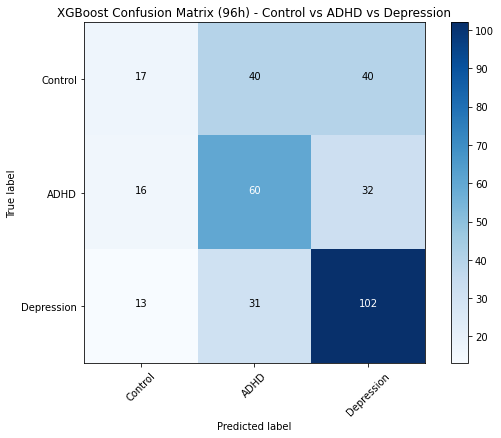

In [31]:

plot_confusion_matrix(cm           = np.array([[ 17,  40,   40],
                                              [  16,  60,  32],
                                              [  13,  31, 102]]), 
                      normalize    = False,
                      target_names = ['Control','ADHD', 'Depression'],
                      title        = "XGBoost Confusion Matrix (96h) - Control vs ADHD vs Depression")